
# <p style="text-align: center;">MIS382: Advanced Predictive Modeling</p>
# <p style="text-align: center;">Assignment 3</p>
## <p style="text-align: center;">Total points: 75</p>
## <p style="text-align: center;">Due: Tuesday, October 23rd, submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Only one student per team needs to submit the assignment on Canvas.  **Please include the name and UTEID for both students on all submitted files (including this notebook).** In addition, please make sure that **your filename includes your EID** (ex. ss324.jpynb or ss324_mj345.jpypb).

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

## Team : Apoorva Reddy

# Question 1a - Stochastic Gradient Descent (25pts)

1. (5pts) Using stochastic gradient descent, derive the coefficent updates for all 4 coefficients of the model: $$ y = w_0 + w_1x_1 + w_2x_1^2 + w_3x_1x_2 $$ Hint: start from the cost function (Assume sum of squared error). If you write the math by hand, include the image in your notebook.


2. (15pts) Write Python code for an SGD solution to the non-linear model $$ y = w_0 + w_1x_1 + w_2x_1^2 + w_3x_1x_2$$ Try to format similarly to scikit-learn's models. Your class should take as input the learning_rate, regularization_constant and number of epochs. The fit method must take as input X,y and a choice of update_rule as 'sgd' or 'sgd_momentum' or 'rmsprop'(Notes on implementation below). The _predict_ method takes an X value (optionally, an array of values). Use your new gradient descent regression to predict the data given in 'samples.csv', for 15 epochs, using learning rates: [.0001, .001, .01, 0.1, 1, 10, 100] and regularization constants in the range: [0,10,100] . Plot MSE and the $w$ parameters as a function of epoch (for 15 epochs) for the best 2 combinations of learning_rate and regularization for SGD, SGD-Momentum and RMSProp. I.e., you should have one plot of MSE and another for the parameter updates for SGD, SGD-Momentum and RMSProp (6 plots total).


3. (2pts) Report the MSE at the end of 15 epochs for both combinations.


4. (3pts) Based on the experiments, which of the 3 techniques allowed for larger initial setting of the learning_rate? Why?


# Notes on SGD with momentum
Momentum helps accelerate SGD in relevant direction and dampens the oscillations. It tries to maintain the direction in which the gradient vector was already pointing and adjusts the direction slowly with the new gradients. The steps can be listed below :
1. v[t] = mu * v[t-1] - (learning_rate)*(gradient)
2. w = w + v

Set mu = 0.90. Initialize v with zeros.


# Notes on RMSProp
RMSProp (http://ruder.io/optimizing-gradient-descent/) differs from vanilla SGD in that the learning rate of each weight changes over updates. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate.  In particular, it uses a moving average of squared gradients as cache. The learning_rate is divided by the cache, resulting in a different learning rate for each weight. A consequence of this update rule is that weights that have already seen large gradients (made large jumps) make smaller updates in subsequent iterations.
Specifically, the steps can be listed as below:
1. cache = (decay_rate)*(cache) + (1 - decay_rate)*(gradients^2) 
2. weights = weights - ((learning_rate)/sqrt(cache+1e-6))*gradients

Use decay_rate = 0.90. Initialize cache with zeros.

# (Optional) Notes on Training with Gradient Descent
1. Compute error: This consists of a prediction error and a regularization term. From an implementation perspective, this is a function that takes as input the truth, prediction and regularization hyperparameter and returns an error
2. Compute gradients: Take a derivative of the error in terms of the weights. This can be modelled as a function that takes as input the error and features and returns the gradients for each weight
3. Update weights: Weight updates can be done using vanilla SGD or adaptive techniques. The update function takes as inputs the gradient and hyperparameters and returns the new weights.

## Answer

In [114]:
%pylab inline
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


1

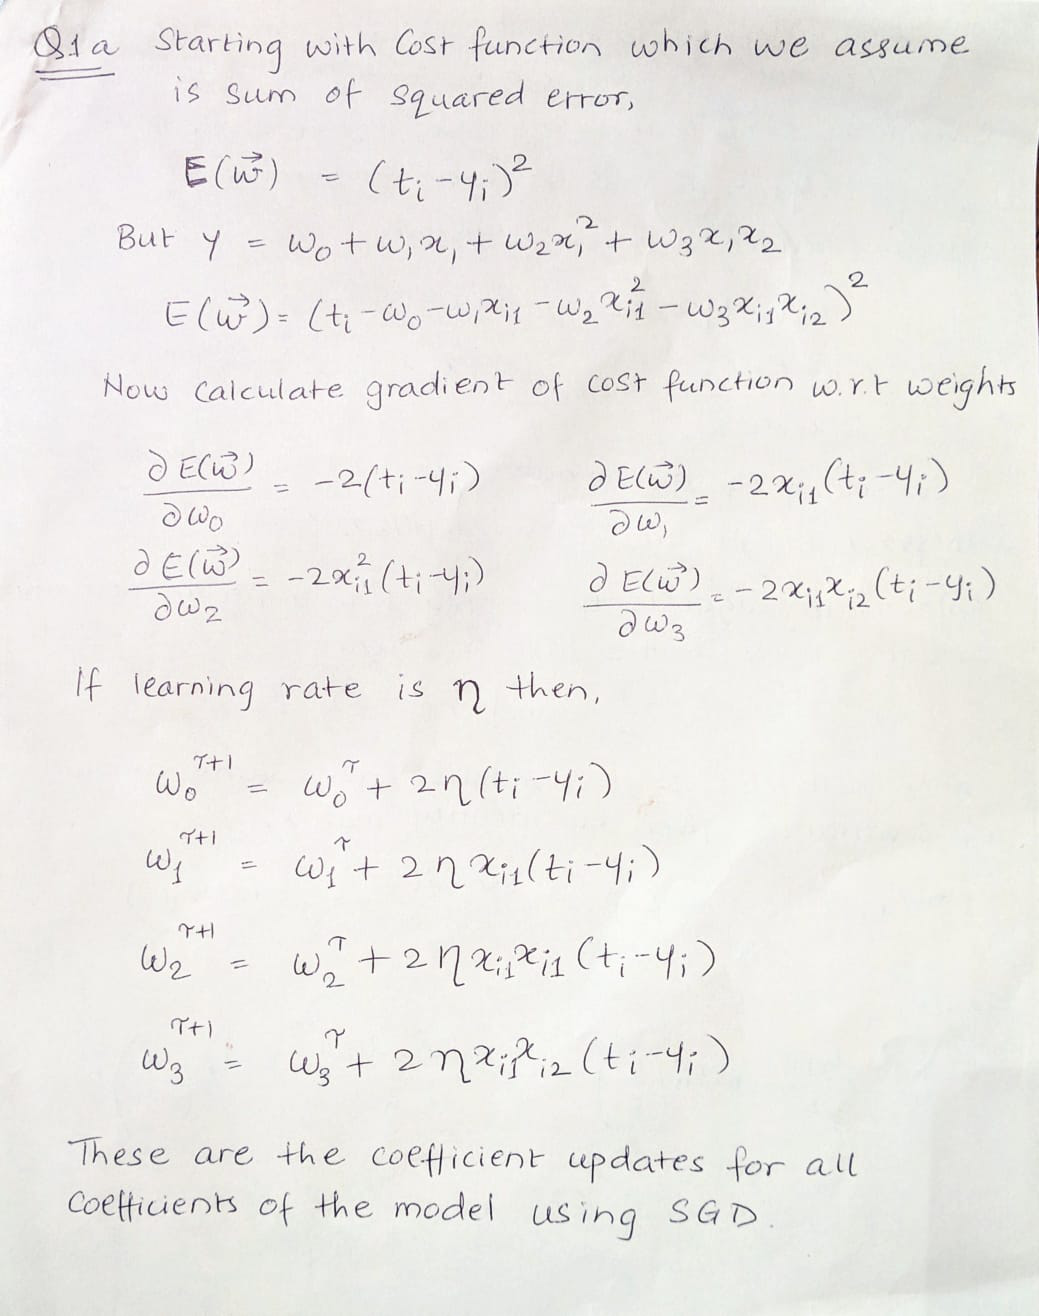

In [123]:
Image.open('Question1a.png')

# Question 2 - Multi-layer perceptron Regressor (15 pts)

In this question, you will explore the application of Multi-layer Perceptron (MLP) regression using sklearn package in Python;
http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html.


We will use the OpenCL gemm kernel performance prediction dataset for this problem; https://archive.ics.uci.edu/ml/datasets/SGEMM+GPU+kernel+performance.

Following code will pre-process the data and split the data into training and test set using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with **random state 30** and **test_size = 0.25**.

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
%matplotlib inline

data = pd.read_csv('sgemm_product.csv') 
data['target'] = 0.25*(data['Run1 (ms)'] + data['Run2 (ms)']+ data['Run3 (ms)'] + data['Run4 (ms)'])
y = data['target']
y = y.as_matrix()
X = data.drop(['target','Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=30)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((181200, 14), (181200L,), (60400, 14), (60400L,))


One more thing to use in this problem is [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on original data, use StandardScaler to make each feature centered ([Example](http://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html#sphx-glr-auto-examples-applications-plot-prediction-latency-py)). Whenever you have training and test data, fit a scaler on training data and use this scaler on test data. Here, scale only features (independent variables), not target variable y. 

In [54]:
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

1) (5pts) Use [sklearn.neural_nework.MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) to do a 5-fold cross validation using sklearn's [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). The cross validation must be performed on the **training data**. Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=30, learning_rate_init = 0.005
    
Now, consider the following settings for the number of hidden units:
    
   (a) *hidden_layer_sizes = (2,)* 
   
   (b) *hidden_layer_sizes = (10,)*
   
   (c) *hidden_layer_sizes = (30,)*
   
   (d) *hidden_layer_sizes = (50,)*
   
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model.
   
   
2) (5pts) Now, using the same parameters used in part 1), train MLPRegressor models on the entire training set and report the RMSE score for both the trainnig and testing sets (again, use StandardScaler). Which of the four models ((a)-(d)) performs the best? Briefly analyze and discuss the results, commenting on the number of hidden units.


3) (5pts) MLPRegressor has a built-in attribute *loss\_curve\_* which returns the loss at each epoch (misleadingly referred to as "iteration" in scikit documentation, though they use epoch in the actual code!). For example, if your model is named as *my_model* you can call it as *my\_model.loss\_curve\_* ([example](http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py)). Plot three curves using below conditions (a, b, c) in one figure, where *X-axis* is epoch  number and *Y-axis* is squared root of *loss\_curve\_* valu;:

   (a) *hidden_layer_sizes = (1,)* 
   
   (b) *hidden_layer_sizes = (5,)*
   
   (c) *hidden_layer_sizes = (10,)*

In [55]:
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.model_selection import cross_val_score

#1)

In [56]:
hidden_layer_sizes_list=[(2,),(10,),(30,),(50,)]
for i in [0,1,2,3]:
    regressor_model=MLPRegressor(hidden_layer_sizes=hidden_layer_sizes_list[i],activation ='tanh', solver = 'sgd', learning_rate='constant',random_state=30,batch_size=30, learning_rate_init = 0.005)
    regressor_model.fit(X_train,y_train)
    print hidden_layer_sizes_list[i]
    print np.sqrt(abs(cross_val_score(regressor_model, X_train, y_train, cv=5,scoring='neg_mean_squared_error').mean()))

(2,)
275.1089913188039
(10,)
212.24353590663443
(30,)
199.50181971888864
(50,)
174.7830993492606


#2)

In [6]:
for i in [0,1,2,3]:
    regressor_model=MLPRegressor(hidden_layer_sizes=hidden_layer_sizes_list[i],activation ='tanh', solver = 'sgd', learning_rate='constant',random_state=30,batch_size=30, learning_rate_init = 0.005)
    regressor_model.fit(X_train,y_train)
    y_train_pred=regressor_model.predict(X_train)
    y_test_pred=regressor_model.predict(X_test)
    print "Hidden_layer_size ",hidden_layer_sizes_list[i]
    print "Training error ", np.sqrt(mean_squared_error(y_train, y_train_pred))
    print "Testing error ", np.sqrt(mean_squared_error(y_test, y_test_pred))

Hidden_layer_size  (2,)
Training error  282.24100222360545
Testing error  276.35744919886986
Hidden_layer_size  (10,)
Training error  228.52847303299265
Testing error  225.21881970710152
Hidden_layer_size  (30,)
Training error  187.7953768333451
Testing error  184.74498673598097
Hidden_layer_size  (50,)
Training error  146.31634347897258
Testing error  145.6103682823535


Clearly we can see that as the number of hidden layers increase the accuracy of the prediction increases. It's evident that hidden layyer with 50 neurons performs the best when compared to the other sizes.
However if we increase the number of hidden layers to a large number, then it might overfit the training
error which might result in high testing error

#3)

In [57]:
#hidden_layer_sizes_list=[(1,),(5,),(10,)]
import matplotlib.pyplot as plt
hidden_layers = [1,5,10]
loss={}

for i in hidden_layers:
    regressor_model=MLPRegressor(activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,batch_size=30, learning_rate_init = 0.005, hidden_layer_sizes=(i,))
    regressor_model.fit(X_train,y_train)
    loss[i] = np.sqrt(regressor_model.loss_curve_)


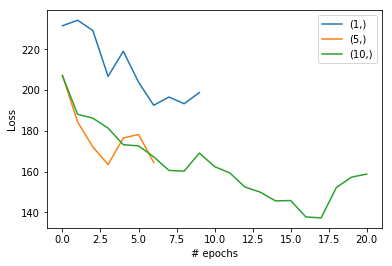

In [59]:
for i in hidden_layers:
    plt.plot(pd.Series(loss[i]))
plt.xlabel ('# epochs')
plt.ylabel('Loss')
plt.legend(['(1,)', '(5,)', '(10,)'])

# Question 3 - [Kaggle Competition] Mercedes-Benz Greener Manufacturing (25 pts)

In this problem, we are going to explore a Kaggle competition: [Mercedes-Benz Greener Manufacturing](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing). Your goal is to obtain the best score you can in this competition.

The first step is to make a Kaggle account. Then find this competition and read the competition details and the description of the dataset. 

I have converted the categorical variables to numbers. The dataset is available as **'q3_train.csv'** and **'q3_test.csv'** along with the assignment. Please use this dataset for building your models. Upload your predicted values to kaggle to get the score.

Your work should meet the following requirements:

1. Data Preprocessing. 
 * Conduct some data preprocessing. (Hint: see if there is any outlier and remove them).
 * Impute the missing values (if any).
 
2. Predictive Models. 
 * You have to create three models: Lasso regression, Ridge regression and multilayer perceptron. For Lasso and Ridge regression, optimize the alphas using cross validation. Multilayer perceptron can have one hidden layer. You may try other predictive models to get better scores (optional). 
3. Get a score of 0.51 or higher on the **Private Leaderboard**. Take a screenshot of your private score after submission as proof. You can click My Submissions tab to see the history of your submissions. It will show both Public Leaderboard & Private Leaderboard score. Your highes score should be visible in the screenshot.

Briefly describe your work on each of these steps. Explain (very briefly) what approaches you tried, what worked and what did not work. Mention your team's kaggle name and include a screen shot of your public submission score. Finally, try your best to win this competition!

## Answer

In [13]:
# Input data

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
q3_test = pd.read_csv("q3_test.csv").drop_duplicates().set_index("ID")
q3_train=pd.read_csv("q3_train.csv").drop_duplicates().set_index("ID")
print q3_test.shape
print q3_train.shape
#Y_train=q3_train['y']
#q3_train=q3_train.drop('y',axis=1)

(4209, 376)
(4209, 377)


In [15]:
# Cleaning data

In [61]:
#checking for null values 
sum(q3_train.isnull().sum())

0L

In [63]:
q3_train.describe()

y           X0           X1           X2           X3  \
count  4209.000000  4209.000000  4209.000000  4209.000000  4209.000000   
mean    100.669318    29.760751    11.113566    17.306486     2.919696   
std      12.679381    13.738338     8.531001    10.899914     1.739912   
min      72.110000     0.000000     0.000000     0.000000     0.000000   
25%      90.820000    19.000000     3.000000     8.000000     2.000000   
50%      99.150000    35.000000    13.000000    16.000000     2.000000   
75%     109.010000    43.000000    20.000000    25.000000     5.000000   
max     265.320000    46.000000    26.000000    43.000000     6.000000   

                X4           X5           X6           X8          X10  \
count  4209.000000  4209.000000  4209.000000  4209.000000  4209.000000   
mean      2.997862    13.340223     6.807318    11.611309     0.013305   
std       0.073900     8.250832     2.916973     7.037888     0.114590   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       3.000000     5.000000     6.000000     5.000000     0.000000   
50%       3.000000    15.000000     7.000000    11.000000     0.000000   
75%       3.000000    21.000000     9.000000    18.000000     0.000000   
max       3.000000    28.000000    11.000000    24.000000     1.000000   

          ...              X375         X376         X377         X378  \
count     ...       4209.000000  4209.000000  4209.000000  4209.000000   
mean      ...          0.318841     0.057258     0.314802     0.020670   
std       ...          0.466082     0.232363     0.464492     0.142294   
min       ...          0.000000     0.000000     0.000000     0.000000   
25%       ...          0.000000     0.000000     0.000000     0.000000   
50%       ...          0.000000     0.000000     0.000000     0.000000   
75%       ...          1.000000     0.000000     1.000000     0.000000   
max       ...          1.000000     1.000000     1.000000     1.000000   

              X379         X380         X382         X383         X384  \
count  4209.000000  4209.000000  4209.000000  4209.000000  4209.000000   
mean      0.009503     0.008078     0.007603     0.001663     0.000475   
std       0.097033     0.089524     0.086872     0.040752     0.021796   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              X385  
count  4209.000000  
mean      0.001426  
std       0.037734  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000  

[8 rows x 377 columns]

In [65]:
##removing outliers 
from scipy import stats
#q3_train[(np.abs(stats.zscore(q3_train))<=3).any(axis=1)].shape
q3_train_f=q3_train[q3_train.apply(lambda x: np.abs(x - x.mean()) / x.std()> 3).any(axis=1)]
q3_train_f.describe()

y           X0           X1           X2           X3  \
count  3855.000000  3855.000000  3855.000000  3855.000000  3855.000000   
mean    100.613043    29.866148    10.908949    17.850843     2.843320   
std      12.852766    13.795893     8.543108    11.069498     1.733201   
min      72.110000     0.000000     0.000000     0.000000     0.000000   
25%      90.775000    19.000000     3.000000     8.000000     2.000000   
50%      99.110000    34.000000    12.000000    16.000000     2.000000   
75%     108.990000    43.000000    20.000000    26.000000     5.000000   
max     265.320000    46.000000    26.000000    43.000000     6.000000   

                X4           X5           X6           X8          X10  \
count  3855.000000  3855.000000  3855.000000  3855.000000  3855.000000   
mean      2.997665    13.284825     6.873411    11.656031     0.014527   
std       0.077216     8.244909     2.920776     7.014846     0.119663   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       3.000000     5.000000     6.000000     6.000000     0.000000   
50%       3.000000    15.000000     7.000000    12.000000     0.000000   
75%       3.000000    21.000000     9.000000    18.000000     0.000000   
max       3.000000    28.000000    11.000000    24.000000     1.000000   

          ...              X375         X376         X377         X378  \
count     ...       3855.000000  3855.000000  3855.000000  3855.000000   
mean      ...          0.287938     0.062516     0.343709     0.022568   
std       ...          0.452861     0.242122     0.475007     0.148541   
min       ...          0.000000     0.000000     0.000000     0.000000   
25%       ...          0.000000     0.000000     0.000000     0.000000   
50%       ...          0.000000     0.000000     0.000000     0.000000   
75%       ...          1.000000     0.000000     1.000000     0.000000   
max       ...          1.000000     1.000000     1.000000     1.000000   

              X379        X380         X382         X383         X384  \
count  3855.000000  3855.00000  3855.000000  3855.000000  3855.000000   
mean      0.010376     0.00882     0.008301     0.001816     0.000519   
std       0.101347     0.09351     0.090742     0.042579     0.022774   
min       0.000000     0.00000     0.000000     0.000000     0.000000   
25%       0.000000     0.00000     0.000000     0.000000     0.000000   
50%       0.000000     0.00000     0.000000     0.000000     0.000000   
75%       0.000000     0.00000     0.000000     0.000000     0.000000   
max       1.000000     1.00000     1.000000     1.000000     1.000000   

              X385  
count  3855.000000  
mean      0.001556  
std       0.039426  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000  

[8 rows x 377 columns]

In [66]:
Y=q3_train_f['y']
q3_train_f=q3_train_f.drop('y',axis=1)

In [67]:
## eliminating redundant pairs ( u'll notice that there are X pairs with correaltion coeffcient equal to 1)
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, q3_train_f.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(q3_train_f, n=5):
    au_corr = q3_train_f.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(q3_train_f)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    au_corr.to_csv('au_corr.csv')
    return au_corr[0:n]
print("Top Absolute Correlations")
print(get_top_abs_correlations(q3_train_f, 20))

Top Absolute Correlations
X184  X266    1.0
X88   X243    1.0
X62   X172    1.0
X263  X279    1.0
X232  X263    1.0
X113  X134    1.0
X60   X385    1.0
X54   X136    1.0
X33   X39     1.0
X88   X122    1.0
X230  X254    1.0
X113  X147    1.0
X89   X245    1.0
X35   X37     1.0
X142  X158    1.0
X226  X326    1.0
X90   X242    1.0
X53   X214    1.0
X54   X76     1.0
X134  X147    1.0
dtype: float64


In [68]:
## Dropping columns tht have a high correlation score (>0.99)
def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() >threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

In [69]:
q3_train_f_uncor=trimm_correlated(q3_train_f,0.99)
q3_train_f_uncor.shape

(3855, 316)

In [70]:
from sklearn.model_selection import train_test_split
Y_ln=np.log(Y)
X_train, X_test, Y_train, Y_test = train_test_split(q3_train_f_uncor,Y,test_size = 0.30, random_state=50)

In [71]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

# Models perfromed 

1) Lasso

2) Ridge 

3) XGBoost

4) MLP

Steps followed in training the dataset:


We'll use a cross-validation generator to select train and cross validate dataset to finetune parameters such as lambda, learning_rate etc. These hyperparameters are extremely critical to the model. Now, if we tune parameters against the Test dataset, we will end up biasing towards the test set and will once again not generalize very well. We will also have no good way to find out since we have essentially trained on all our data.

Fortunately scikit-learn has builit-in packages that can help with this. We'll use a crossvalidation generator that can train the model by tuning the parameters based on a cross-validation subset that is picked from within the training set. A different cv subset will be picked for each iteration, we control the number of iterations. Then we will use these cv/train splits and run a gridsearch function that will evaluate the model with each split and tune parameters to give us the best parameter that gives the optimal result. Also note that we are inputting multiple neighbors to the GridSearch to try out.

In [72]:
# Lasso

In [73]:
lasso = Lasso(random_state=0)
alphas = 10**np.linspace(10,-6,100)*0.5
tuned_parameters = [{'alpha': alphas}]
n_folds = 5
clf_lasso = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False, scoring= 'neg_mean_absolute_error')
clf_lasso.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([5.00000e+09, 3.44631e+09, ..., 7.25414e-07, 5.00000e-07])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

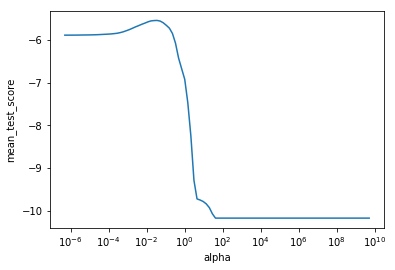

In [74]:
scores = clf_lasso.cv_results_['mean_test_score']
plt.semilogx(alphas, scores)
plt.ylabel('mean_test_score')
plt.xlabel('alpha')
plt.show()

In [79]:
best_alpha_lasso=clf_lasso.best_params_
best_alpha_lasso=best_alpha_lasso.values()[0]
clf_lasso.best_params_

{'alpha': 0.03527401155359316}

In [80]:
clf_lasso = linear_model.Lasso(alpha=best_alpha_lasso)
clf_lasso.fit(X_train,Y_train)
Y_pred= (clf_lasso.predict(X_test))
mean_absolute_error(Y_test, Y_pred)

5.504135864465852

In [81]:
# Ridge

In [82]:
ridge = Ridge(random_state=0)
tuned_parameters = [{'alpha': alphas}]
n_folds = 5

In [83]:
clf_ridge = GridSearchCV(ridge, tuned_parameters, cv=n_folds, refit=False,scoring= 'neg_mean_absolute_error')
clf_ridge.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=0, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([5.00000e+09, 3.44631e+09, ..., 7.25414e-07, 5.00000e-07])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

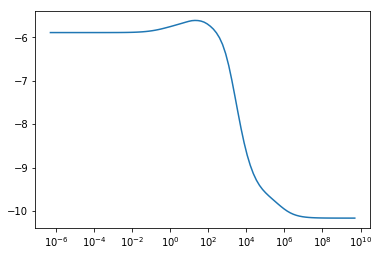

In [84]:
scores = clf_ridge.cv_results_['mean_test_score']
plt.semilogx(alphas, scores)
plt.show()

In [85]:
best_alpha_ridge=clf_ridge.best_params_
best_alpha_ridge=best_alpha_ridge.values()[0]
best_alpha_ridge

19.72103029718824

In [86]:
clf_ridge = linear_model.Ridge(alpha=best_alpha_ridge)
clf_ridge.fit(X_train,Y_train)
Y_pred= (clf_ridge.predict(X_test))
mean_absolute_error(Y_test, Y_pred)

5.670135986829665

In [88]:
# XG Boost
from numpy import loadtxt
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
from sklearn.grid_search  import GridSearchCV 
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [89]:
# fit model no training data
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

In [90]:
gbrt=XGBRegressor()
gbrt.fit(X_train, Y_train)
y_pred=gbrt.predict(X_test) 
mean_absolute_error(Y_test, y_pred)

5.410352351684042

In [42]:
## tuning parameters of XGBoosting 
##Note that we are tuning based on the F1 score 2PR/P+R where P is Precision and R is Recall. 
##This may not always be #the best score to tune our model on. 
param_grid={'n_estimators':[100],
            'learning_rate': [0.1,0.05, 0.02, 0.01],
            'max_depth':[6,4], 'min_samples_leaf':[3,5,9], 
            'max_features':[1.0,0.3,0.1] }
n_jobs=4 
estimator = GradientBoostingRegressor()
clf_xgboost = GridSearchCV(estimator, cv=5, param_grid=param_grid, n_jobs=n_jobs)
clf_xgboost.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': [100], 'max_features': [1.0, 0.3, 0.1], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [6, 4], 'min_samples_leaf': [3, 5, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [78]:
clf_xgboost.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=0.1,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=9,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [76]:
y_train_pred=clf_xgboost.predict(X_train)
y_test_pred=clf_xgboost.predict(X_test)
print "Training error ", (mean_absolute_error(Y_train, y_train_pred))
print "Testing error ", (mean_absolute_error(Y_test, y_test_pred))

Training error  5.1428137677326635
Testing error  5.415158418727683


In [77]:
from sklearn.model_selection import train_test_split
Y_ln=np.log(Y)
X_train, X_test, Y_train, Y_test = train_test_split(q3_train_f_uncor,Y,test_size = 0.30, random_state=50)

In [385]:
# MLP

In [93]:
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

In [106]:
from sklearn.neural_network import MLPClassifier
mlp = MLPRegressor(activation = 'identity', solver = 'sgd', learning_rate='constant', random_state=42,\
                          batch_size=25, learning_rate_init = 0.00001, hidden_layer_sizes=(3,))

In [107]:
mlp.fit(X_train, Y_train)
y_train_pred=mlp.predict(X_train)
Y_pred_mlp = mlp.predict(X_test)

In [108]:
print "Training error ", (mean_absolute_error(Y_train, y_train_pred))
print "Testing error ", (mean_absolute_error(Y_test, Y_pred_mlp))

Training error  5.458133417208123
Testing error  6.104851135868744


In [98]:
#Predictions on final test set 

In [109]:
q3_test_f_uncor=q3_test[list(q3_train_f_uncor.columns.values)]
Y_pred_lasso= pd.DataFrame(clf_lasso.predict(q3_test_f_uncor),index=q3_test_f_uncor.index.values,columns=[('ID','y')])
Y_pred_ridge=pd.DataFrame(clf_ridge.predict(q3_test_f_uncor),index=q3_test_f_uncor.index.values,columns=[('ID','y')])
Y_pred_xgboost1=pd.DataFrame(gbrt.predict(q3_test_f_uncor),index=q3_test_f_uncor.index.values,columns=[('ID','y')])
y_pred_MLP=pd.DataFrame(mlp.predict(StandardScaler().fit_transform(q3_test_f_uncor.values)),index=q3_test_f_uncor.index.values,columns=[('ID','y')])

In [110]:
#writing to csv
Y_pred_lasso.to_csv("Y_pred_lasso.csv",sep=',',columns=[('ID','y')])
Y_pred_ridge.to_csv("Y_pred_ridge.csv",sep=',',columns=[('ID','y')])
Y_pred_xgboost1.to_csv("Y_pred_xgboost1.csv",sep=',',columns=[('ID','y')])
y_pred_MLP.to_csv("y_pred_MLP.csv",sep=',',columns=[('ID','y')])

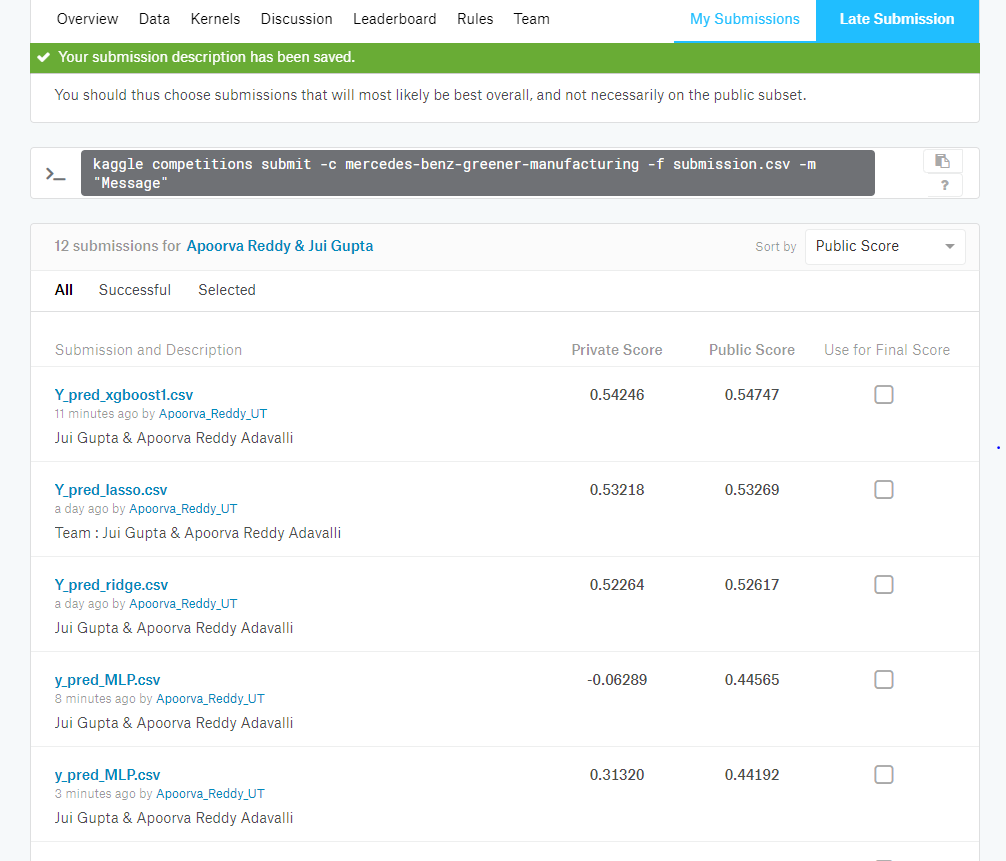

In [115]:
Image.open('Kaggle_final_results.png')

# Question 4 - Bayes Decision Theory (10pts)

a. (2pts) Explain what you understand by class-conditional likelihood, class priors, and posterior probability of a class given an input, and the relationship between them. Please define all symbols and equations used explicitly.

b. (5pts) Suppose you want to learn a binary classifier to predict whether or not a customer will buy a TV. The class label is 0 if the patient does not buy and 1 if he/she does. For each customer, you are given two features, x1 is the per hour salary and x2 is the age. Assume that the class conditional distribution $p(x_1,x_2|C)$ is Gaussian. The mean salary and age of the people who do buy a TV is 40 and 27 respectively and that of those who don't is 16 and 20. Assume that both classes of customers have the same covariance given by the Identity matrix. Further, your sales data suggests that only 1 in 5 people actually bought a TV in the last few years. Mathematically derive the (optimal) Bayes decision boundary for this problem.

c. (3pts) Write a script to sample 100 customers from each class (C = 0; 1) under the assumed distribution and the estimated parameters and plot their features. Plot the decision boundary you obtained in the part (b) on the same plot.

## Answer

a)

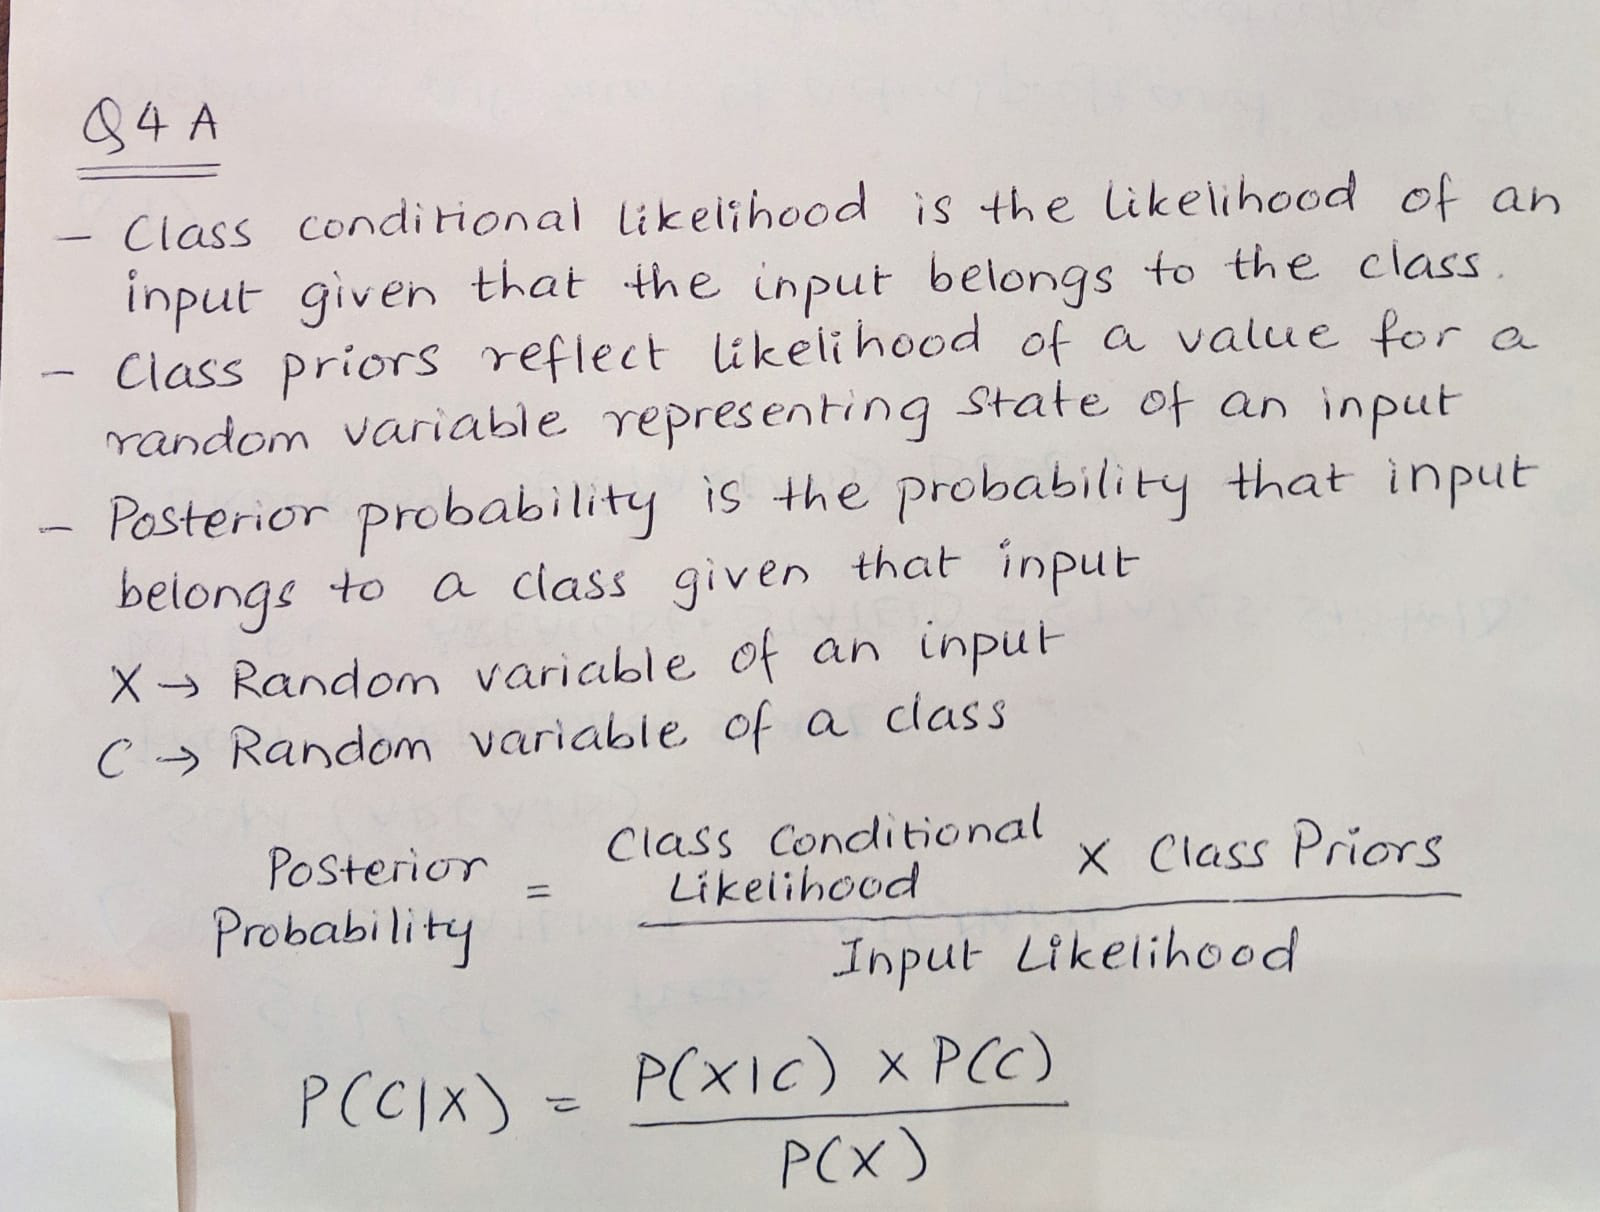

In [125]:
Image.open('Question4a.png')

b)

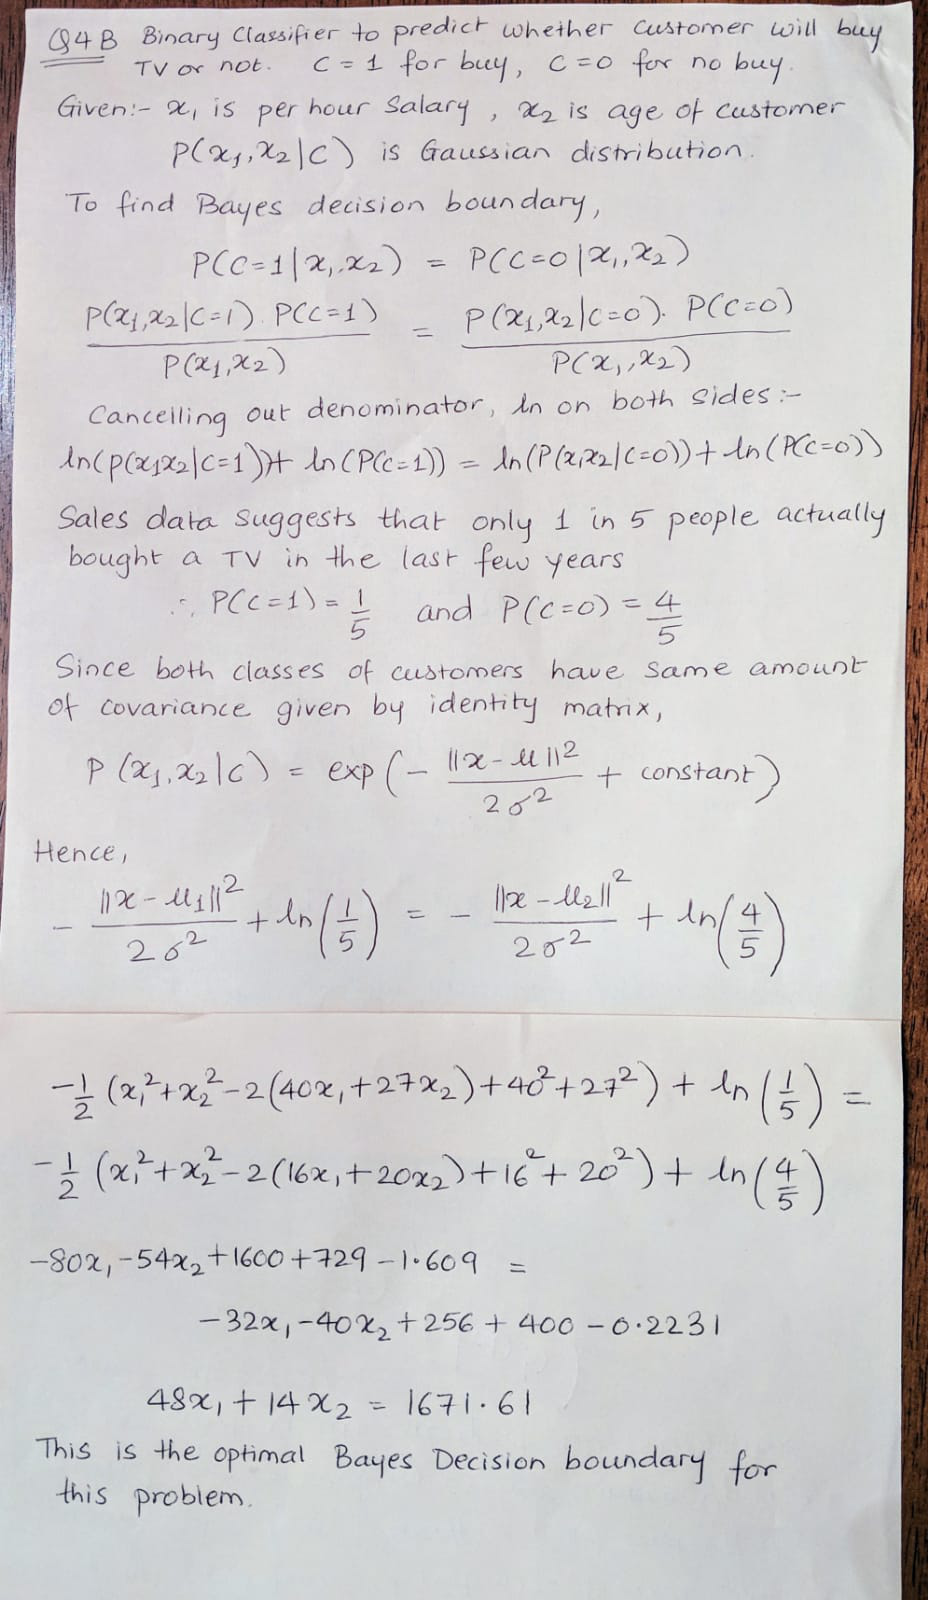

In [128]:
Image.open('Question4b.png')

c)

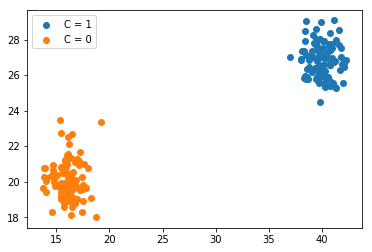

In [117]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from sklearn.naive_bayes import GaussianNB

np.random.seed(100)
mean1 = [40, 27]
covariance1 = np.eye(2)

mean2 = [16, 20]
covariance2 = np.eye(2)

X = np.concatenate([np.random.multivariate_normal(mean1, covariance1, 100),
                    np.random.multivariate_normal(mean2, covariance2, 100)])
y = np.zeros(200)
y[:100] = 1


plt.scatter(X[:100, 0], X[:100, 1])
plt.scatter(X[100:, 0], X[100:, 1])
plt.legend(('C = 1','C = 0'))